In [1]:
import fasttext
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import string
from collections import Counter

2025-04-22 00:42:16.082706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745282536.331686      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745282536.403718      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load dataset
dsk = pd.read_excel('/kaggle/input/kurdishkdfnd/KDFND_Anlyzed_Cleaned_Filtered_Labeld.xlsx')


In [3]:
dsk.nunique()

ID                            90905
Text                         100961
Text_Translate_to_English    100411
URL                          100800
date                             12
Source                          103
label                             5
Unnamed: 7                        3
dtype: int64

In [4]:
dsk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100966 entries, 0 to 100965
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         100962 non-null  float64
 1   Text                       100962 non-null  object 
 2   Text_Translate_to_English  100961 non-null  object 
 3   URL                        100962 non-null  object 
 4   date                       100962 non-null  object 
 5   Source                     100962 non-null  object 
 6   label                      100965 non-null  object 
 7   Unnamed: 7                 3 non-null       float64
dtypes: float64(2), object(6)
memory usage: 6.2+ MB


In [5]:
# Remove null Rows
dsk = dsk.dropna(subset=['Text'])

# Remove columns that not needed
dsk["Article"] = dsk["Text"]
dsk['label'] = dsk['label'].map({'Real': 0, 'Fake': 1})  # Convert labels to 0 and 1
dsk = dsk[['Article', 'label']].dropna()


In [6]:
from sklearn.utils import resample
# Assuming 'dsk' is your DataFrame and you have a binary label column called 'label'
# Split the dataset into majority and minority classes
majority_class = dsk[dsk['label'] == 0]
minority_class = dsk[dsk['label'] == 1]

# Perform undersampling on the minority class
majority_undersampled = resample(majority_class,replace=True, n_samples=len(minority_class), random_state=42)  # For reproducibility

# Combine majority class with the undersampled minority class
dskb = pd.concat([minority_class, majority_undersampled])

# Shuffle the dataset
dskb = dskb.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced class distribution:")
print(dskb['label'].value_counts())

Balanced class distribution:
label
0    50211
1    50211
Name: count, dtype: int64


In [7]:
# Tokenize and count word frequencies
all_words = ' '.join(dskb).split()
word_freq = Counter(all_words)

# Identify potential stopwords (e.g., words appearing very frequently)
potential_stopwords = [word for word, freq in word_freq.items() if freq > 1]

# Example stopwords list (refined manually)
kurdish_stopwords = [
     "ئێمە","ئێوە","ئەم","ئەو"
     ,"ئەوان","ئەوەی","بۆ","بێ","بێجگە","بە","بەبێ","بەدەم","بەردەم","بەرلە","بەرەوی","بەرەوە","بەلای","بەپێی","تۆ","تێ","جگە","دوای","دوو","دە"
     ,"دەکات","دەگەڵ","سەر","لێ","لە","لەبابەت","لەباتی","لەبارەی","لەبرێتی","لەبن","لەبەر","لەبەینی","لەدەم","لەرێ","لەرێگا","لەرەوی","لەسەر","لەلایەن"
     ,"لەناو","لەنێو","لەو","لەپێناوی","لەژێر","لەگەڵ","من","ناو","نێوان","هەر","هەروەها","و","وەک","پاش","پێ","پێش","چەند","کرد","کە","ی"

] + potential_stopwords

kupunctuation = {'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?',
                 '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'}

# Convert set to list before concatenation
ku_stopwords = kurdish_stopwords + list(kupunctuation)

def rremove_stopwords(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
    
# Apply the function to each article
dskb['Article'] = dskb['Article'].apply(lambda text: rremove_stopwords(text, ku_stopwords))
dskb

,Article,label
0,شکستی ڕاهێنەرە یان پێکهاتە؟ ئارسیناڵ لەم وەرزە...,0
1,پۆلیسی دهۆک جادوگەرێکی دەستگیرکرد بزانن چی کرد...,1
2,سەرکەوت شەمسەدین نەوەی نوێ ئێستا هێزێکی ناڕەسە...,1
3,وریابە تێنەکویت درۆی حیزب وسکیولارەکان,1
4,قبوڵە بەرای تۆ؟ جەعفەر شێخ مستەفا نزا دەکەم یە...,1
...,...,...
100417,گەنجێک هەڵەبجە کۆتایی ژیانی خۆی هێنا نیوەڕوی ئ...,1
100418,فراکسیۆنەکانی گۆڕان پەرلەمانی کوردستان ئەنجومە...,0
100419,دەیان هاوڵاتی ئێرانی لیستی موچەی شەهیداندان,0
100420,باشترین ڕێزلێنان پەرلەمانی کوردستان ڕێزلێنان ئ...,1


In [8]:
def wordpre(text):
    if not isinstance(text, str):
        return ""  # Return empty string for non-string inputs
    # Remove URLs, special characters, and numbers
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)      # Remove numbers
    
    # Remove extra spaces
    text = text.strip()
   
    return text

##  Applying the wordpre method to the dataset
dskb['Article']=dskb['Article'].apply(wordpre)
dskb

,Article,label
0,شکستی ڕاهێنەرە یان پێکهاتە ئارسیناڵ لەم وەرزەد...,0
1,پۆلیسی دهۆک جادوگەرێکی دەستگیرکرد بزانن چی کردووە,1
2,سەرکەوت شەمسەدین نەوەی نوێ ئێستا هێزێکی ناڕەسە...,1
3,وریابە تێنەکویت درۆی حیزب وسکیولارەکان,1
4,قبوڵە بەرای تۆ جەعفەر شێخ مستەفا نزا دەکەم یەز...,1
...,...,...
100417,گەنجێک هەڵەبجە کۆتایی ژیانی خۆی هێنا نیوەڕوی ئ...,1
100418,فراکسیۆنەکانی گۆڕان پەرلەمانی کوردستان ئەنجومە...,0
100419,دەیان هاوڵاتی ئێرانی لیستی موچەی شەهیداندان,0
100420,باشترین ڕێزلێنان پەرلەمانی کوردستان ڕێزلێنان ئ...,1


/tmp/ipykernel_75/3323649149.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'blue', ax = ax ).set_title('Distribution of Text length for True News')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Text length for True News')

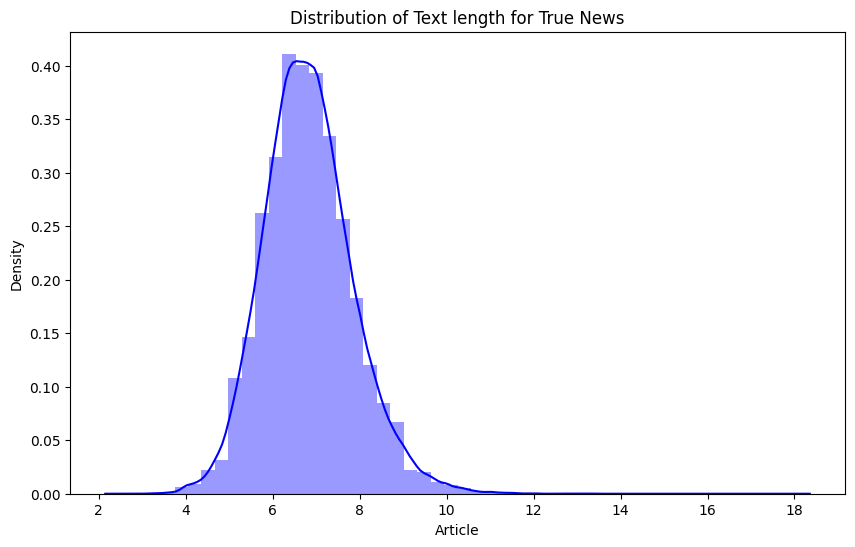

In [9]:
fix, ax = plt.subplots(figsize = (10, 6))

text_words = dsk[dsk['label'] == 0 ]['Article'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'blue', ax = ax ).set_title('Distribution of Text length for True News')

/tmp/ipykernel_75/1029870825.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'red', ax = ax ).set_title('Distribution of Text length for Fake News')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


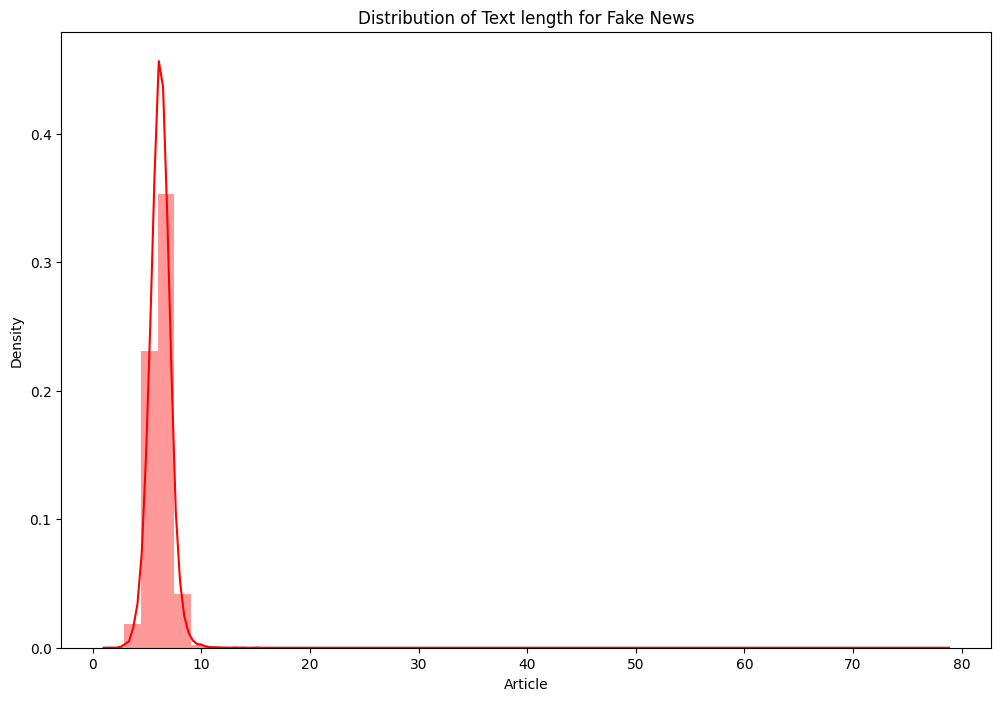

In [10]:
fix, ax = plt.subplots(figsize = (12, 8))

text_words = dsk[dsk['label'] == 1 ]['Article'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'red', ax = ax ).set_title('Distribution of Text length for Fake News')

plt.show()

In [11]:
dskb['label1'] = "__label__" + dskb['label'].astype(str)

In [12]:
dskb['label_description'] = dskb['label1'].astype(str) + " " + dskb['Article'].astype(str)
dskb

,Article,label,label1,label_description
0,شکستی ڕاهێنەرە یان پێکهاتە ئارسیناڵ لەم وەرزەد...,0,__label__0,__label__0 شکستی ڕاهێنەرە یان پێکهاتە ئارسیناڵ...
1,پۆلیسی دهۆک جادوگەرێکی دەستگیرکرد بزانن چی کردووە,1,__label__1,__label__1 پۆلیسی دهۆک جادوگەرێکی دەستگیرکرد ب...
2,سەرکەوت شەمسەدین نەوەی نوێ ئێستا هێزێکی ناڕەسە...,1,__label__1,__label__1 سەرکەوت شەمسەدین نەوەی نوێ ئێستا هێ...
3,وریابە تێنەکویت درۆی حیزب وسکیولارەکان,1,__label__1,__label__1 وریابە تێنەکویت درۆی حیزب وسکیولارەکان
4,قبوڵە بەرای تۆ جەعفەر شێخ مستەفا نزا دەکەم یەز...,1,__label__1,__label__1 قبوڵە بەرای تۆ جەعفەر شێخ مستەفا نز...
...,...,...,...,...
100417,گەنجێک هەڵەبجە کۆتایی ژیانی خۆی هێنا نیوەڕوی ئ...,1,__label__1,__label__1 گەنجێک هەڵەبجە کۆتایی ژیانی خۆی هێن...
100418,فراکسیۆنەکانی گۆڕان پەرلەمانی کوردستان ئەنجومە...,0,__label__0,__label__0 فراکسیۆنەکانی گۆڕان پەرلەمانی کوردس...
100419,دەیان هاوڵاتی ئێرانی لیستی موچەی شەهیداندان,0,__label__0,__label__0 دەیان هاوڵاتی ئێرانی لیستی موچەی شە...
100420,باشترین ڕێزلێنان پەرلەمانی کوردستان ڕێزلێنان ئ...,1,__label__1,__label__1 باشترین ڕێزلێنان پەرلەمانی کوردستان...


In [13]:
train, test = train_test_split(dskb, test_size = 0.2)

In [14]:
train.to_csv("fake_news_train.txt", columns = ['label_description'], index=False, sep=' ', header=False,
    quoting=3, escapechar=' ', mode='w')
test.to_csv("fake_news_test.txt", columns = ['label_description'], index=False, sep=' ', header=False,
    quoting=3, escapechar=' ', mode='w')

In [15]:
# Train FastText Model
fasttext_model = fasttext.train_supervised(input="fake_news_train.txt", lr=0.5, epoch=25, wordNgrams=2, dim=300)
#y_predic = fasttext_model.test("fake_news_test.txt")

Read 1M words
Number of words:  162717
Number of labels: 2
Progress: 100.0% words/sec/thread:  392570 lr:  0.000000 avg.loss:  0.055898 ETA:   0h 0m 0s% words/sec/thread:   58923 lr:  0.498389 avg.loss:  0.612252 ETA:   0h 4m41s% words/sec/thread:  385766 lr:  0.124458 avg.loss:  0.072867 ETA:   0h 0m10s 9s


In [16]:
# Function to get FastText vector safely
def fasttext_vector(text):
    if isinstance(text, str):  # Ensure text is a string
        text = text.replace("\n", " ").strip()  # Remove newlines
        return fasttext_model.get_sentence_vector(text)
    return np.zeros(300)  # Return zero vector for empty/non-string values


In [17]:
# Apply FastText vectors to dataset
X_fasttext = np.array([fasttext_vector(text) for text in dskb['Article']])
# Function to get FastText vector
y = np.array(dskb['label'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y, test_size=0.2, random_state=42)

In [18]:
# Tokenization
max_words = 10000
max_len = 200
# First ensure all articles are strings
dskb['Article'] = dskb['Article'].astype(str)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dskb['Article'])
X_sequences = tokenizer.texts_to_sequences(dskb['Article'])
X_padded = pad_sequences(X_sequences, maxlen=max_len)


In [19]:
# Embedding Matrix from FastText
embedding_matrix = np.zeros((max_words, 300))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_matrix[i] = fasttext_model.get_word_vector(word)


**LSTM**

In [33]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, weights=[embedding_matrix], input_length=max_len, trainable=True),
    LSTM(128, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile & Train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6931
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.4998 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.4983 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Accuracy: 0.4998
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


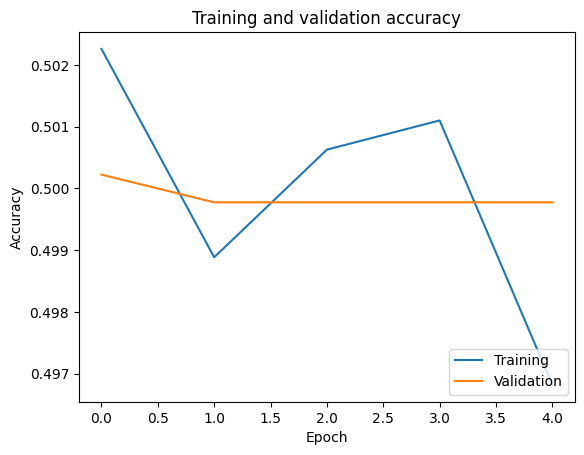

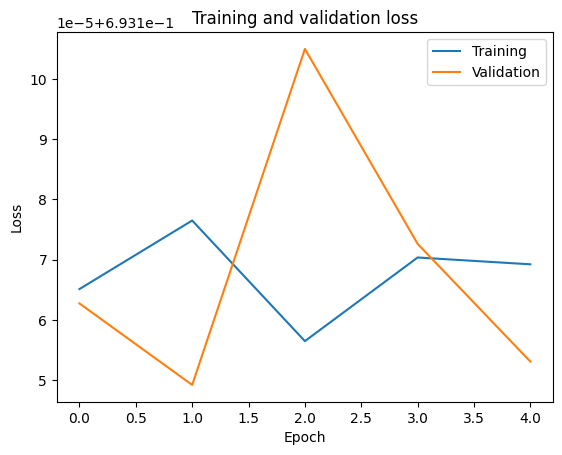

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

**Improved LSTM Accuracy and Runtime in model by Delete Embedding**

In [40]:
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile & Train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [41]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.7748 - loss: 0.5078 - val_accuracy: 0.9736 - val_loss: 0.1055
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.9589 - loss: 0.1916 - val_accuracy: 0.9740 - val_loss: 0.0940
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.9744 - loss: 0.0970 - val_accuracy: 0.9729 - val_loss: 0.0935
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9727 - loss: 0.0997 - val_accuracy: 0.9721 - val_loss: 0.0950
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9731 - loss: 0.0976 - val_accuracy: 0.9724 - val_loss: 0.0945
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Accuracy: 0.9724
Precision: 0.9766
Recall: 0.9680
F1-Score: 0.9723


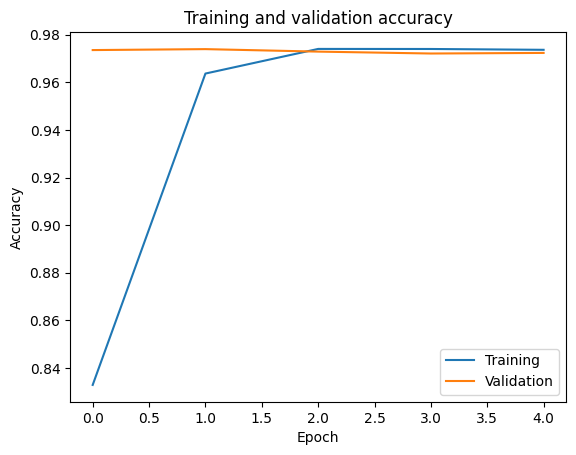

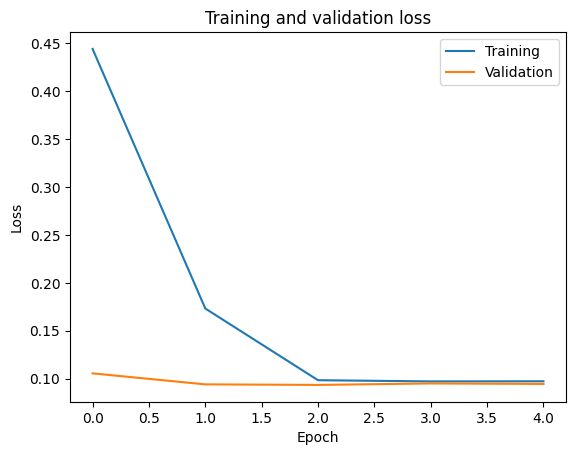

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [20]:
# Assuming X_train is 2D (samples, features)
X_train_sh = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Add timesteps dimension
X_test_sh = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


**BiLSTM**

In [21]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, weights=[embedding_matrix], input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model before fitting
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-22 00:47:23.982649: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 687s 541ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 679s 540ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 681s 542ms/step - accuracy: 0.4969 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 677s 539ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 680s 542ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
628/628 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step
Accuracy: 0.5002
Precision: 0.5002
Recall: 1.0000
F1-Score: 0.6669


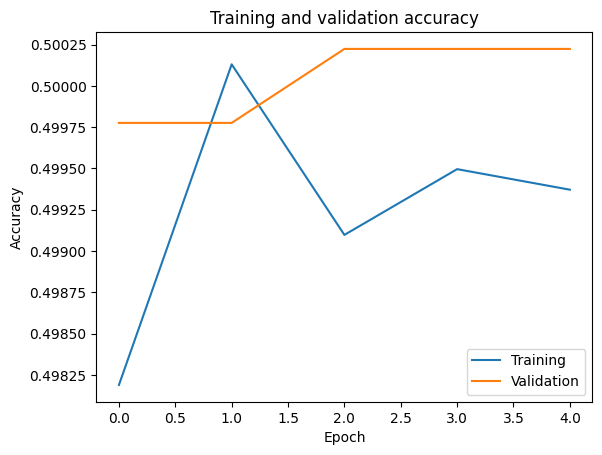

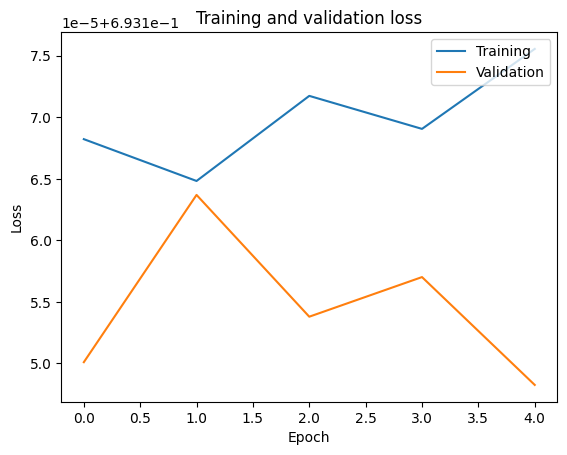

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

**Improved BiLSTM Accuracy and Runtime in model by Deleting Embedding**

In [24]:
# BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
history = model.fit(X_train_sh, y_train, epochs=5, batch_size=64, validation_data=(X_test_sh, y_test))

y_pred = (model.predict(X_test_sh) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 251s 195ms/step - accuracy: 0.8558 - loss: 0.3993 - val_accuracy: 0.9724 - val_loss: 0.0989
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 261s 194ms/step - accuracy: 0.9539 - loss: 0.1351 - val_accuracy: 0.9726 - val_loss: 0.0997
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 243s 193ms/step - accuracy: 0.9541 - loss: 0.1414 - val_accuracy: 0.9718 - val_loss: 0.1002
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 244s 195ms/step - accuracy: 0.9539 - loss: 0.1395 - val_accuracy: 0.9719 - val_loss: 0.1000
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 244s 194ms/step - accuracy: 0.9533 - loss: 0.1405 - val_accuracy: 0.9723 - val_loss: 0.0997
628/628 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step
Accuracy: 0.9723
Precision: 0.9720
Recall: 0.9727
F1-Score: 0.9723


**CNN**

In [55]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, weights=[embedding_matrix], input_length=max_len),
    # Reshape input if needed (if not using Embedding)
    # Conv1D + Pooling for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu'), 
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),  # Critical for classification!
    # Dense layers for classification
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5017 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5035 - loss: 0.6931 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.4998 - val_loss: 0.6931
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.4998
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


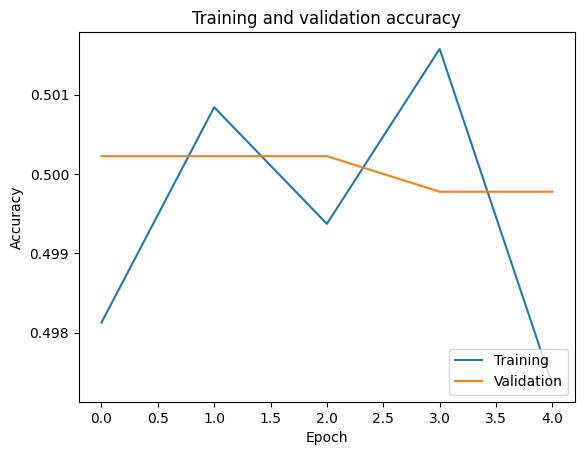

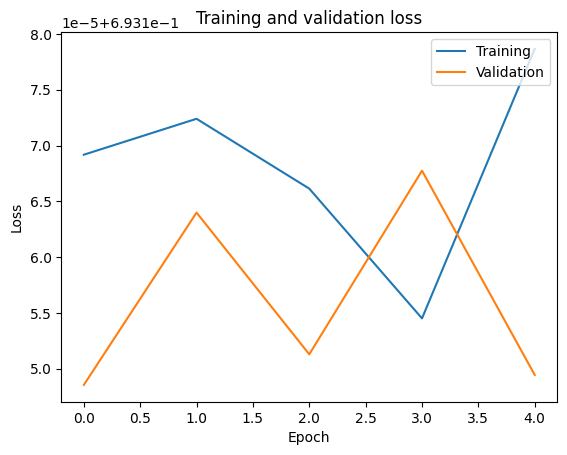

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

**Improved Cnn Accuracy and Runtime in model by Deleting Embedding**

In [58]:

model = Sequential([
    # Reshape input if needed (if not using Embedding)
    # Conv1D + Pooling for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_len, 1)),  # Input shape (timesteps, features)
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),  # Critical for classification!
    # Dense layers for classification
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Epoch 1/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7110 - loss: 0.5906 - val_accuracy: 0.9740 - val_loss: 0.1524
Epoch 2/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9735 - loss: 0.1458 - val_accuracy: 0.9741 - val_loss: 0.1015
Epoch 3/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9730 - loss: 0.1180 - val_accuracy: 0.9708 - val_loss: 0.1127
Epoch 4/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9739 - loss: 0.1154 - val_accuracy: 0.9741 - val_loss: 0.0971
Epoch 5/5
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9738 - loss: 0.1109 - val_accuracy: 0.9740 - val_loss: 0.0973
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.9740
Precision: 0.9690
Recall: 0.9793
F1-Score: 0.9741


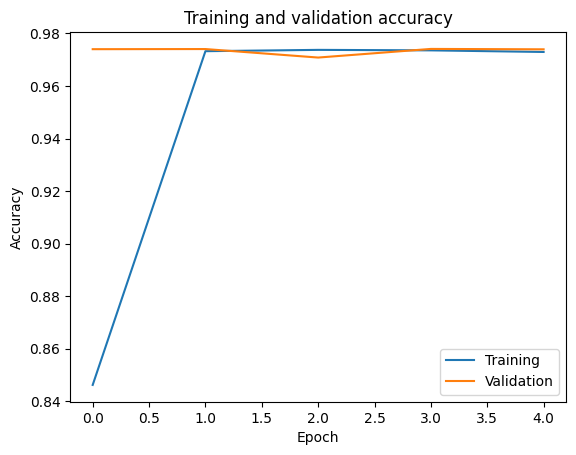

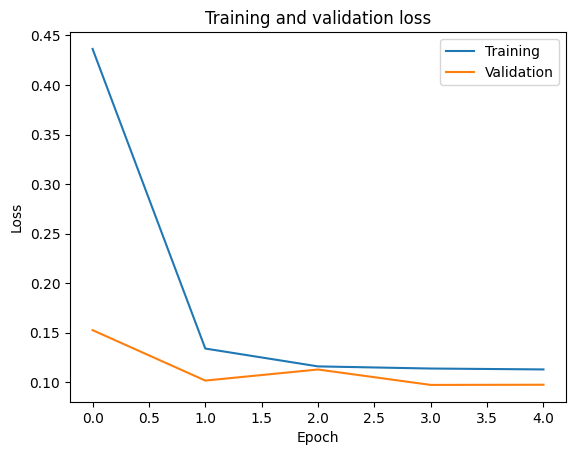

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()